In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

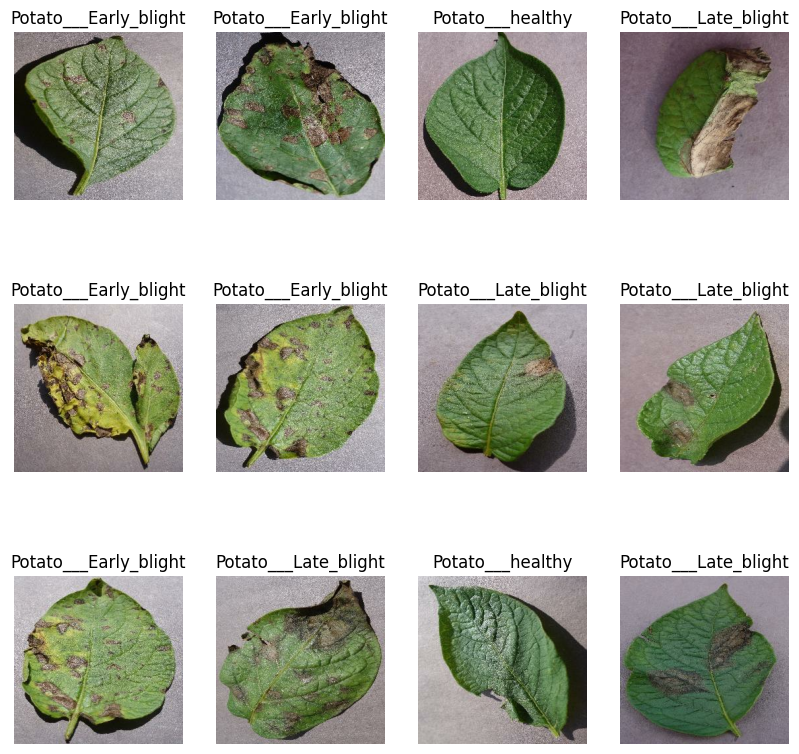

In [6]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
# 80% → training
# 10% → validation
# 10% → test

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

In [26]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5370 - loss: 0.8855 - val_accuracy: 0.5938 - val_loss: 0.8794
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7436 - loss: 0.5928 - val_accuracy: 0.8542 - val_loss: 0.3982
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8611 - loss: 0.3484 - val_accuracy: 0.8490 - val_loss: 0.3036
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8773 - loss: 0.3215 - val_accuracy: 0.8698 - val_loss: 0.2819
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9375 - loss: 0.1629 - val_accuracy: 0.9583 - val_loss: 0.1062
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9248 - loss: 0.2030 - val_accuracy: 0.9583 - val_loss: 0.1239
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9502 - loss: 0.1260 - val_accuracy: 0.9062 - val_loss: 0.2487
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9601 - loss: 0.1044 - val_accuracy: 0.9427 - val_loss

In [36]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.4453 - loss: 1.0888


In [53]:
scores

[1.0888160467147827, 0.4453125]

In [54]:
history

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names
len(dataset)
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
len(dataset)
# 80% → training
# 10% → validation
# 10% → test
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
len(train_ds)
test_ds = dataset.skip(54)
len(test_ds)
val_size = 0.1
len(dataset)*val_size
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)
def get_dataset_part

In [43]:
history.params

NameError: name 'history' is not defined

In [44]:
history.history.keys()

NameError: name 'history' is not defined

In [45]:
history.history['accuracy']

NameError: name 'history' is not defined

In [46]:
len(history.history['accuracy'])

NameError: name 'history' is not defined

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

NameError: name 'acc' is not defined

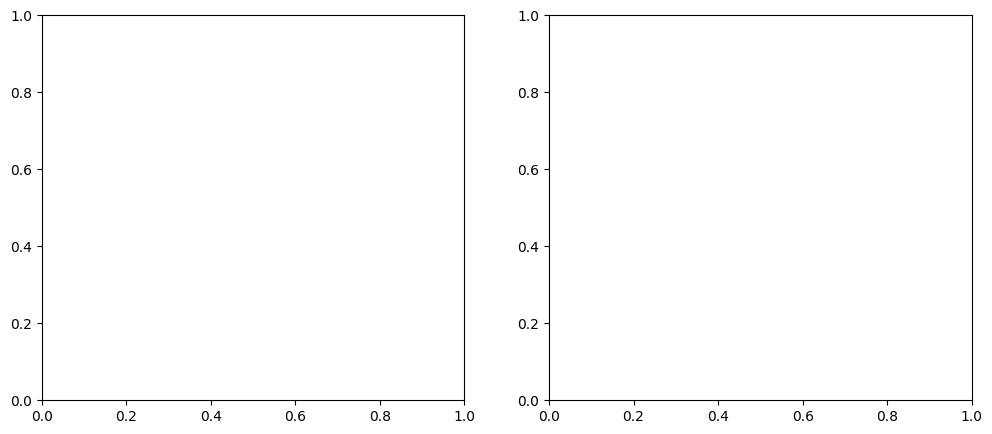

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(EPOCHS), acc, label='Training Accuracy')
ax1.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')

ax2.plot(range(EPOCHS), loss, label='Training Loss')
ax2.plot(range(EPOCHS), val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
predicted label: Potato___healthy


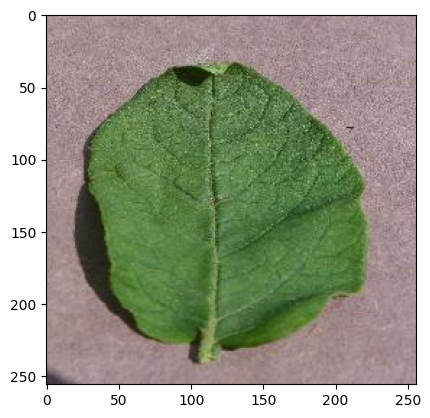

In [56]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


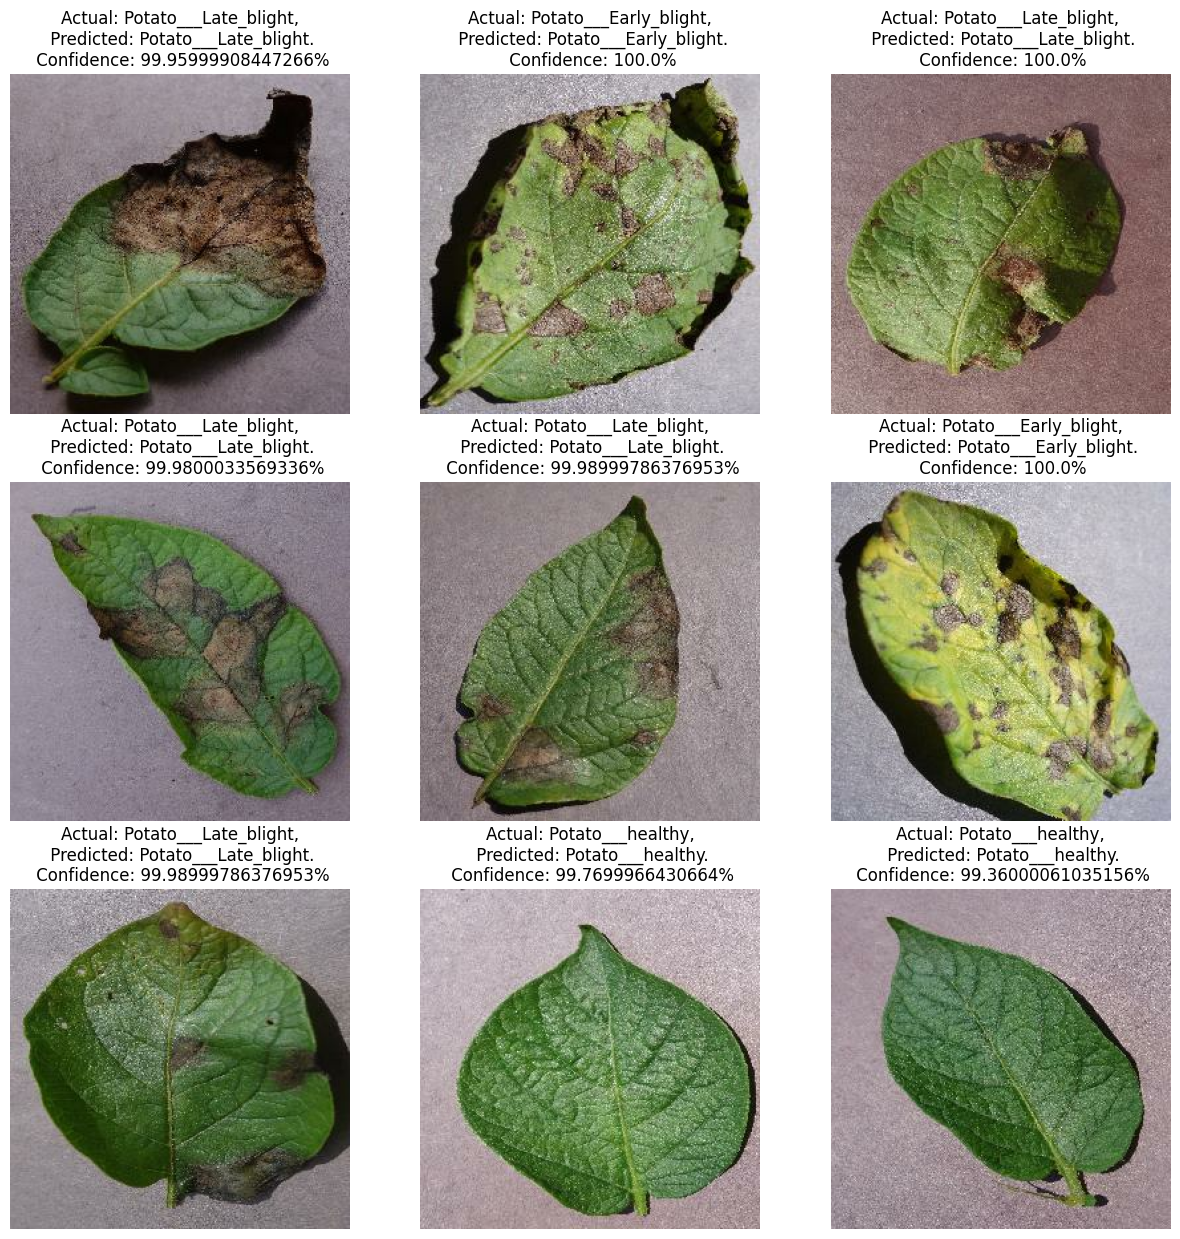

In [58]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [60]:
import os

os.makedirs("../saved_models", exist_ok=True)

# collect only numeric filenames (strip extensions)
existing_versions = []
for fname in os.listdir("../saved_models"):
    name, ext = os.path.splitext(fname)
    if name.isdigit():
        existing_versions.append(int(name))

# if no numeric versions exist, start at 0
model_version = max(existing_versions + [0]) + 1

# save with .keras extension
model.save(f"../saved_models/{model_version}.keras")

In [61]:
from tensorflow.keras.models import load_model

model = load_model("../saved_models/1.keras")  # or the version I want